In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from io import open
import glob
import os
import unicodedata
import string
from typing import Dict, List, Callable
import random
import time
import math


alphabet: str = string.ascii_letters + " .,;'"

def read_data() -> Dict[str, List[str]]:
    dic = {}  # {language_name: [name, ...]}
    data_path: str = "../data/names/*.txt"

    for filename in glob.glob(data_path):
        category = os.path.splitext(os.path.basename(filename))[0]
        lines = open(filename, encoding="utf-8").read().strip().split("\n")
        unicodeToAscii: Callable[[str], str] = lambda s: "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn" and c in alphabet)
        lines = [unicodeToAscii(line) for line in lines]
        dic[category] = lines

    return dic



# example
print("num letters:", len(alphabet))
print("num categories:", len(read_data().keys()))

num letters: 57
num categories: 18


In [118]:
def one_hot_encode(s: str) -> torch.Tensor:
    """
    encode names into one-hot tensor: put a 1 in the position of the character in the alphabet and 0s elsewhere, then stack them.
    shape: <len(s) x 1 x len(alphabet)>
    """
    tensor = torch.zeros(len(s), 1, len(alphabet))
    for i, c in enumerate(s):
        tensor[i][0][alphabet.index(c)] = 1

    return tensor



# example
print(one_hot_encode('Jones').size())

for i in range(len('Jones')):
    print(f"i={i} [{'Jones'[i]}] - ", end=' ')
    for j in range(len(alphabet)):
        content = str(one_hot_encode('Jones')[i][0][j].item())
        content = content.replace('1.0', '\033[92m1\033[0m')
        content = content.replace('0.0', '0')
        print(content, end=' ')
    print()

torch.Size([5, 1, 57])
i=0 [J] -  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
i=1 [o] -  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
i=2 [n] -  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
i=3 [e] -  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
i=4 [s] -  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 


In [119]:
def get_train_example(data):
    category = random.choice(list(data.keys()))
    line = random.choice(data[category])
    category_tensor = torch.tensor([list(data.keys()).index(category)], dtype=torch.long) # just a number
    line_tensor = one_hot_encode(line) # <len(line) x 1 x len(alphabet)>
    return category, line, category_tensor, line_tensor



# example
for i in range(10):
    category, line, category_tensor, line_tensor = get_train_example(read_data())
    print('category =', category, '| line =', line)

category = French | line = Guillory
category = Spanish | line = Fuentes
category = French | line = Daniau
category = Italian | line = Ricci
category = Vietnamese | line = Duong
category = English | line = Aziz
category = Italian | line = Selmone
category = Polish | line = Winogrodzki
category = Vietnamese | line = Chau
category = Arabic | line = Touma


In [128]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size, hidden_size) # input to hidden
        self.h2h = nn.Linear(hidden_size, hidden_size) # hidden to hidden
        self.h2o = nn.Linear(hidden_size, output_size) # hidden to output

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden)) # tanh(linear(input) + linear(hidden))
        
        output = self.h2o(hidden) # linear(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)



# example: one training step
input = one_hot_encode('Albert')
hidden = torch.zeros(1, 128) # previous / initial hidden state
rnn = RNN(len(alphabet), 128, len(read_data().keys()))
output, next_hidden = rnn(input[0], hidden) # run for 'A' in 'Albert'

print(output, next_hidden)
print(output.size()) # <1 x n_categories> -> probability of each category

tensor([[-3.0503, -2.8180, -3.0281, -2.8884, -2.8722, -2.9639, -2.9331, -2.7987,
         -2.8870, -2.9997, -2.9311, -2.7553, -2.8651, -2.7619, -2.8023, -2.9185,
         -2.8506, -2.9675]], grad_fn=<LogSoftmaxBackward0>) tensor([[ 0.0034,  0.1737, -0.0662, -0.0150,  0.1377, -0.0553, -0.0260,  0.0764,
         -0.2131, -0.0539,  0.0239, -0.0576, -0.0244,  0.1721, -0.0059, -0.0733,
         -0.1264, -0.0208, -0.0029, -0.1412, -0.2694,  0.1354,  0.2865, -0.0943,
         -0.1563,  0.1724,  0.0370,  0.0709,  0.0427,  0.1675,  0.0120, -0.0443,
          0.0847,  0.1569, -0.0964, -0.0691,  0.0279, -0.0057,  0.0022,  0.1510,
         -0.0576,  0.0766,  0.0643, -0.0670, -0.0297,  0.1804,  0.1894,  0.0584,
         -0.1597, -0.1065,  0.1473,  0.1780, -0.0571,  0.1101,  0.0856,  0.0272,
          0.1084,  0.1560, -0.0040,  0.0430, -0.0743,  0.0426, -0.0221, -0.1052,
         -0.0007, -0.1081,  0.1752, -0.2045, -0.1391, -0.2399, -0.0917,  0.1643,
         -0.0236,  0.0590,  0.1081, -0.0744,  0.0

In [140]:
def train_loop(data, rnn, loss_fn, n_iters):
    current_loss = 0
    all_losses = []
    
    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = get_train_example(data)

        # unravel the RNN
        output = None
        hidden = rnn.init_hidden()
        rnn.zero_grad()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        assert output is not None

        # compute loss
        loss = loss_fn(output, category_tensor)
        loss.backward()
        current_loss += loss.item()

        # use gradients to update parameters element-wise
        for p in rnn.parameters():
            p.data.add_(p.grad.data, alpha=-learning_rate) # type: ignore

        # log progress at random intervals
        print_every = 5000
        if iter % print_every == 0:
            max_prob_idx = output.topk(1)[1][0].item()
            guess: str = list(data.keys())[max_prob_idx]
            print(f"{iter / n_iters * 100:.0f}% | loss: {loss:.4f} | ({line}) -> {guess} | {'true' if guess == category else 'false ' + '(' +  category + ')'}")

        # averages the loss
        plot_every = 1000
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

    return all_losses


hyperparams = {
    "hidden_size": 128,
    "learning_rate": 0.005, # very sensitive
    "n_iters": 100000,
}
data = read_data()
rnn = RNN(len(alphabet), hyperparams["hidden_size"], len(data.keys()))
loss_fn = nn.NLLLoss() # negative log likelihood loss - since the last layer is log softmax

all_losses = train_loop(data, rnn, loss_fn, hyperparams["n_iters"])

5% | loss: 2.2067 | (Dolan) -> Arabic | false (English)
10% | loss: 1.0878 | (Bazzi) -> Arabic | true
15% | loss: 0.1717 | (Saidbaev) -> Russian | true
20% | loss: 1.1977 | (Tanzer) -> German | true
25% | loss: 1.7311 | (Taylor) -> Scottish | true
30% | loss: 0.6098 | (Prieto) -> Spanish | true
35% | loss: 0.9587 | (Vaccaro) -> Italian | true
40% | loss: 3.1169 | (Armer) -> German | false (English)
45% | loss: 1.4364 | (Cruz) -> Spanish | false (Portuguese)
50% | loss: 1.9552 | (Kaspar) -> Arabic | false (German)
55% | loss: 0.4408 | (O'Brien) -> Irish | true
60% | loss: 1.9761 | (Guirguis) -> Portuguese | false (Arabic)
65% | loss: 2.1525 | (Meyer) -> French | false (German)
70% | loss: 0.7110 | (Jin) -> Chinese | true
75% | loss: 3.0779 | (Wyman) -> Russian | false (German)
80% | loss: 0.7133 | (Kamisaka) -> Japanese | true
85% | loss: 0.2766 | (Jez) -> Polish | true
90% | loss: 0.4049 | (Pang) -> Chinese | true
95% | loss: 0.0351 | (Shim) -> Korean | true
100% | loss: 1.3449 | (Gomu

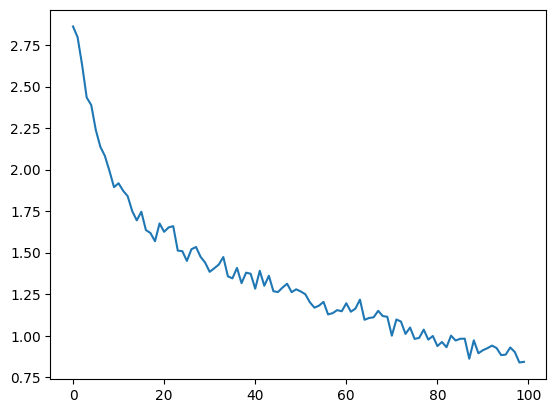

In [ ]:
plt.figure()
plt.plot(all_losses)

/var/folders/g6/xn7nvvtn4ng5pf9bhxfs7p2m0000gn/T/ipykernel_65834/3649271960.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/g6/xn7nvvtn4ng5pf9bhxfs7p2m0000gn/T/ipykernel_65834/3649271960.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


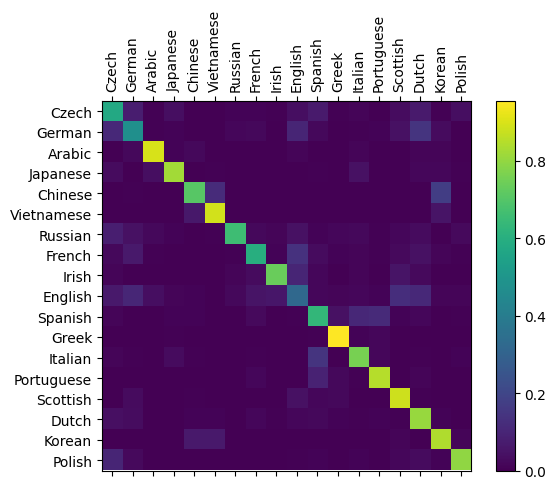

In [ ]:
n_categories = len(data.keys())

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = get_train_example()
    output = evaluate(line_tensor)
    guess, guess_i = decode_label(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')



> Dovesky
(-0.31) Czech
(-2.14) English
(-2.31) Russian

> Jackson
(-0.10) Scottish
(-2.55) English
(-5.11) French

> Satoshi
(-0.10) Italian
(-3.24) Spanish
(-3.85) Portuguese
